## Image Processing for Transfer Learning 

 * Select Subset of Dataframe for glasses, hats, and beard one vs rest classifier 
 * split into train and test df for model training 
 * view images after keras_preprocessing.image ImageDataGenerator
---

### Import Libraries

In [22]:
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [4]:
# load dataframe
df_pics = pd.read_pickle('../pickle_files/pic_df.pkl')
df_pics.head(2)

,eyewear,hat,beard
00018.jpg,0,0,1
00034.jpg,0,0,1


### Select DataFrame based upon label of interest 

 * balance out class labels to roughly 50:50 
 * use np.random.choice to downsample the majority class 

In [65]:
def class_balance(df, label):
    '''
    inputs:
    df: df_pics from the original pic_label dataframe
    label: label of interest for classification such as no glasses or glasses, a string
    output:
    dataframe with 0 and 1 balanced 
    '''
    np.random.seed(16) # make it reproducible
    sub_df = df_pics[[label]]
    index_0 = sub_df[sub_df[label]==0].index.tolist() # 0_df 
    index_1 = sub_df[sub_df[label]==1].index.tolist()  # 1_df 
    num_0 , num_1 = len(index_0), len(index_1)
    # if more 1 than 0 then downsample 1, vice versa
    if num_0 < num_1:
        chosen_1 = np.random.choice(index_1, replace=False, size=num_0) # choose 1 label with same count as 0 
        inds = index_0+list(chosen_1)
    else:
        chosen_0 = np.random.choice(index_0, replace=False, size=num_1) # choose 0 label with same count as 1
        inds = index_1+list(chosen_0)
    return sub_df.loc[inds]

In [85]:
glasses_df = class_balance(df_pics, 'eyewear')
hats_df = class_balance(df_pics, 'hat')
beard_df = class_balance(df_pics,'beard')

### Get dataframe compatible for image generator 

In [88]:
# turn 0 and 1 into string for flow_from_dataframe in image generator 
def dataframe_processor(df, label):
    '''
    inputs:
    df: dfs created from class_balance function
    label: eyewear, hat, or beard, a string 
    return:
    a dataframe compatible for image generator flow_from_dataframe
    '''
    # colvalue needs to be string for binary classification
    map_dict = {0:'not_'+label, 1:label}
    df_1=df.copy()
    df_1[label]=df[label].map(map_dict)
    # require index column to be an actual colname 
    df_1.reset_index(inplace=True)
    df_1.rename(columns = {'index':'pic_id'}, inplace = True)
    return df_1

In [89]:
# for flow_dataframe:
glasses_df = dataframe_processor(glasses_df,'eyewear')

In [93]:
glasses_df.eyewear.value_counts()

eyewear        316
not_eyewear    316
Name: eyewear, dtype: int64

### split into X_train, X_test and concatenate for image generator 

In [98]:
def train_test_df(df, test_size, label):
    '''
    inputs:
    df: dfs created from dataframe_processor 
    test_size: a float, 0.2 or 0.3 or < 1
    label: a string, eyewear, hat, beard 
    returns:
    test and train dataframes, train first, then test second 
    '''
    # 20% test and 80% train 
    X_train, X_test, y_train, y_test = train_test_split(df['pic_id'], 
                                                        df[label],
                                                        stratify = df[label],
                                                        random_state = 16, test_size = test_size)
    # split into train and test dataframes 
    train_df = pd.DataFrame({'pic_id':X_train, label:y_train})
    test_df = pd.DataFrame({'pic_id':X_test, label:y_test})
    return train_df, test_df 

In [99]:
train_df, test_df = train_test_df(glasses_df, 0.2, 'eyewear')

In [102]:
train_df.eyewear.value_counts(), test_df.eyewear.value_counts()

(eyewear        253
 not_eyewear    252
 Name: eyewear, dtype: int64, not_eyewear    64
 eyewear        63
 Name: eyewear, dtype: int64)

In [103]:
train_df.head(2)

,pic_id,eyewear
235,00964.jpg,not_eyewear
171,00872.jpg,not_eyewear


### Create Image generator and look at pictures 

In [104]:
# data preprocess and data agumentation to help with small data set
def image_generation(train_df, test_df, label, batch_size):
    '''
    inputs:
    train_df and test_df: created from train_test_df function
    label: a string, eyewear, hat, or beard 
    batch_size: process images in batches 
    returns:
    image generators for train and test for visual inspection 
    '''
    # use imagedatageneraor to preprocess and augment the small dataset 
    datagen=ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
    # preprocess both train and test 
    train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col= label,
    batch_size=batch_size,
    seed = 36,
    shuffle = True,
    target_size=(150,150),
    class_mode = 'binary')
    
    test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    seed = 24,
    shuffle = True,
    target_size=(150,150),
    class_mode = 'binary')
    
    return train_generator, test_generator    

In [117]:
# checkout some images 
train, test = image_generation(train_df, test_df,'eyewear', 32)

Found 505 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.


In [115]:
def show_imgs(data_gen, num, batch_size):
    '''
    input:
    data_gen: from image_generation function
    num: number of pictures to view 
    batch_size: consistent in image_generation function
    output:
    images of processed images
    '''
    random_images = np.random.choice(range(batch_size),num)
    x, y = next(data_gen)
    for image in random_images:
        plt.imshow(x[image])
        plt.show()

### view 10 random images

---

### Train

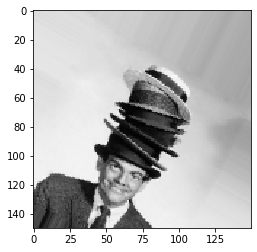

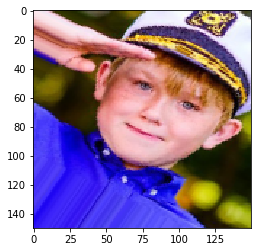

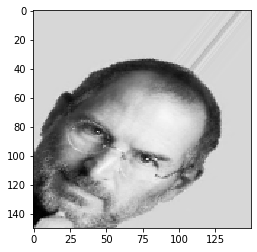

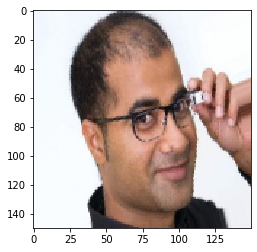

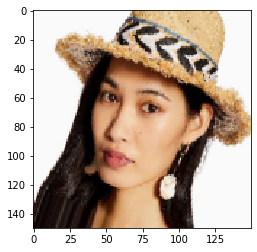

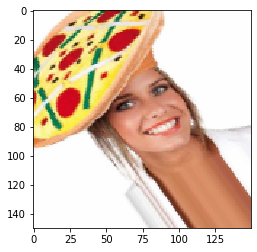

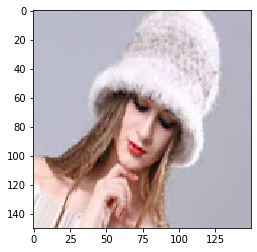

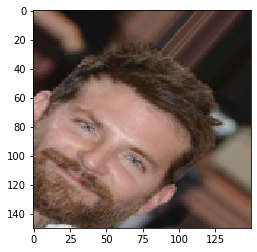

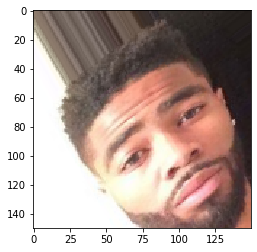

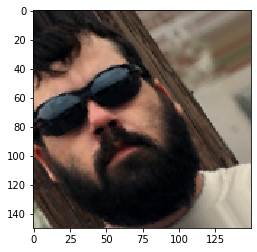

In [119]:
show_imgs(train, 10, 32)

----
### Test

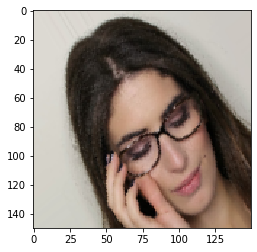

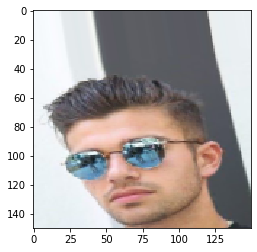

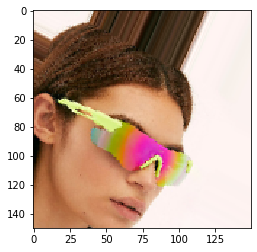

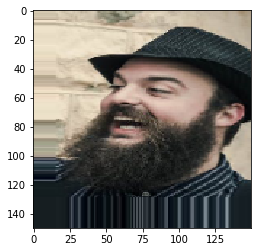

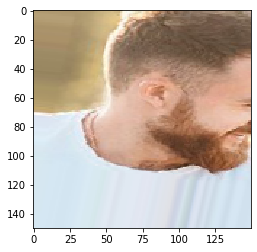

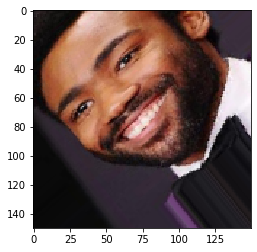

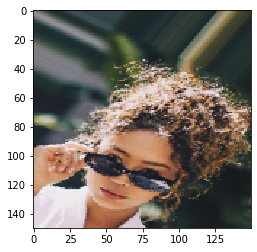

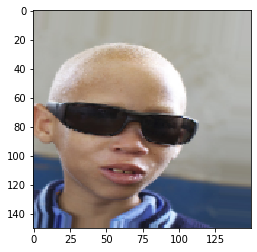

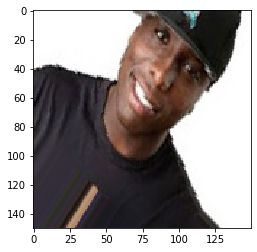

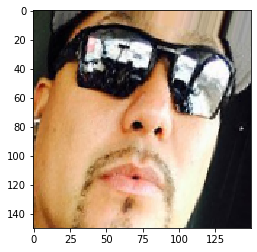

In [118]:
show_imgs(test,10,32)

### Save Train and Test DataFrames for model Tuning

In [120]:
# save train_test_df 
train_df.to_pickle('../pickle_files/train_df_glasses.pkl')
test_df.to_pickle('../pickle_files/test_df_glasses.pkl')

## Use Transfer Learning using vgg16

In [12]:
# intialize the model 
# make sure not to train the top layers 
model_vgg = VGG16(weights = 'imagenet', include_top = False)

W0827 22:41:16.567295 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 22:41:16.568161 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 22:41:16.570595 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 22:41:16.592151 139871847798592 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [13]:
epochs = 10
batch_size = 16

In [24]:
# train to get weights for fine tuning the model 
def save_bottleneck_features():
    train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='data/merged',
    x_col='pic',
    y_col='eyewear',
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    bottleneck_features_train = model_vgg.predict_generator(
        train_gen, 522//batch_size)
    np.save(open('bottleneck_model_weights/bottleneck_features_train.npy','wb'),
           bottleneck_features_train)
    
    test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='data/merged',
    x_col='pic',
    y_col='eyewear',
    batch_size=batch_size,
    shuffle = False,
    target_size=(150,150),
    class_mode = None)
    bottleneck_features_test = model_vgg.predict_generator(
        test_gen, 131//batch_size)
    np.save(open('bottleneck_model_weights/bottleneck_features_test.npy','wb'),
           bottleneck_features_test)

In [25]:
save_bottleneck_features()

Found 522 validated image filenames.
Found 131 validated image filenames.
